# Deploy: Inference

In [7]:
%%capture
# Install ultralytcs library
!pip install ultralytics

In [6]:
%%capture
# Install onnxruntime and onnx
!pip install onnx onnxruntime

In [ ]:
%%capture
!wget https://ultralytics.com/images/bus.jpg

## Ultralytics Inference

In [3]:
from ultralytics import YOLO
import numpy as np
import cv2
import os
from PIL import Image

In [64]:
# coco classes
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']

n = len(classes)
np.random.seed(5)
colors = list(np.random.choice(256, n*3, replace=False).reshape(n, 3).astype(np.uint8))

model_path = "yolov8n-seg.pt"
image_path = "bus.jpg"
score_threshold = 0.5
iou_threshold = 0.5

model = YOLO(model_path)
im_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

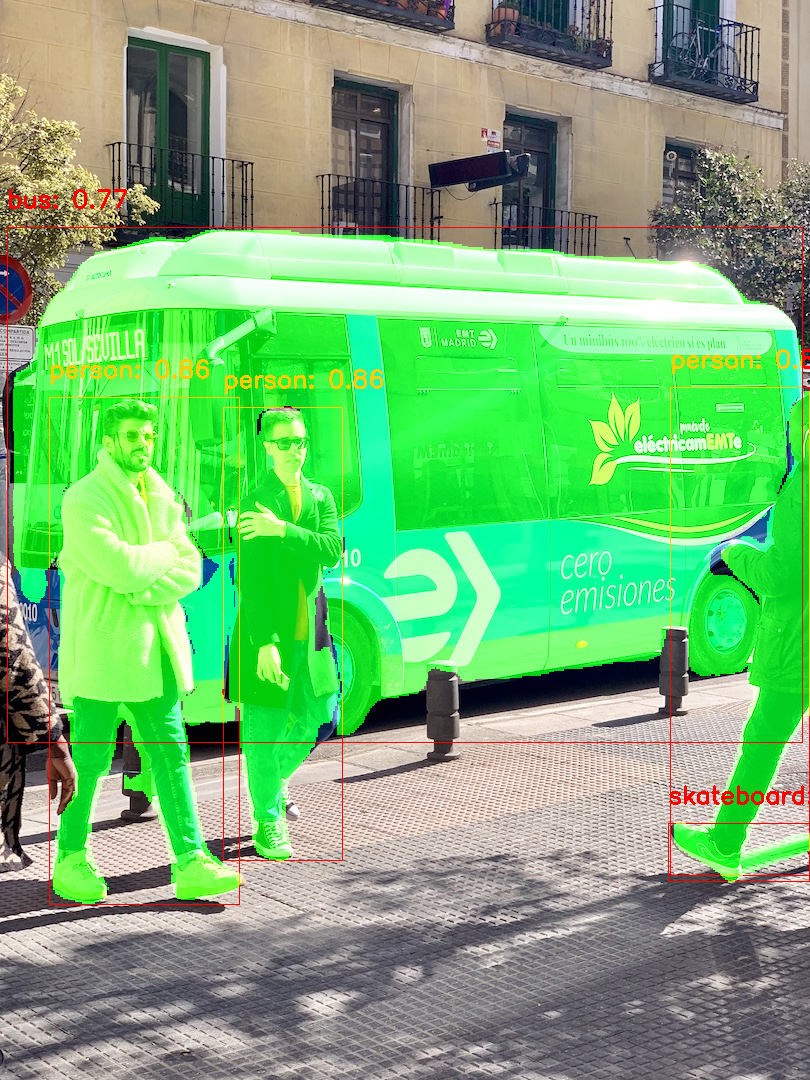

In [65]:
#im_rgb = cv2.resize(im_rgb, (640,640), interpolation=cv2.INTER_LINEAR)
#im_rgb = resize_image(im_rgb,640)
res = model(im_rgb, imgsz=[640,640], conf=score_threshold, iou=iou_threshold, verbose=False)

#res[0].show()

names = model.names
scores = res[0].boxes.conf.cpu().numpy()
class_ids = res[0].boxes.cls.cpu().numpy()
boxes = res[0].boxes.xyxy.cpu().numpy()

im_rgb_draw = im_rgb.copy()
mask_rgb = np.zeros(im_rgb.shape, dtype=np.uint8)
h = im_rgb.shape[0]
w = im_rgb.shape[1]
if len(scores)>0:
    masks = res[0].masks.cpu().data.numpy()
    for box, score, class_id, mask in zip(boxes, scores, class_ids, masks):
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(im_rgb_draw, (x1, y1), (x2, y2), (255, 0, 0), 1)
        class_id = int(class_id)
        label = names[class_id]
        mask = (mask*255).astype(np.uint8)
        mask = cv2.resize(mask, (w,h))
        _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours)>0:
            c_max = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(c_max)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        #cv2.drawContours(im_rgb_draw, [box], 0, (0,255,0), 1)
        cv2.putText(im_rgb_draw, f"{label}: {score:.2f}", (x1, y1 -20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        #cv2.drawContours(im_rgb_draw, [c_max], -1, (0,0,255), 1)  # Adjust thickness and color as needed
        mask_rgb = np.zeros(im_rgb.shape, dtype=np.uint8)
        cv2.drawContours(mask_rgb, [c_max], -1, (0,255,0), -1)  # Adjust thickness and color as needed
        im_rgb_draw = cv2.addWeighted(im_rgb_draw, 1, mask_rgb, 0.8, 0)

display(Image.fromarray(im_rgb_draw))

## Onnx Inference

In [66]:
import onnxruntime as rt
import numpy as np
import cv2
import os
from PIL import Image

In [68]:
# Convert model
# you can visualize the model using netron https://netron.app/
def convert_model(model_path = "yolov8n-seg.pt"):
    # Export model
    m = YOLO(model_path)
    m.export( format="onnx", opset=12,  dynamic=True) #, simplify=True) imgsz=640

model_path = "yolov8n-seg.pt"
if not os.path.exists(model_path.replace(".pt",".onnx")):
    convert_model(model_path)

In [81]:
# coco classes
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']

n = len(classes)
np.random.seed(5)
colors = list(np.random.choice(256, n*3, replace=False).reshape(n, 3).astype(np.uint8))

model_path = "yolov8n-seg.onnx"
image_path = "bus.jpg"
score_threshold = 0.5
iou_threshold = 0.5

# Load model
inf = rt.InferenceSession(model_path)

# Get input name
for i in range(0, len(inf.get_inputs())):
    input_name = inf.get_inputs()[i].name
    print(f"input_{i}: {input_name}")

for i in range(0, len(inf.get_outputs())):
    output_name = inf.get_outputs()[i].name
    print(f"output_{i}: {output_name}")

input_0: images
output_0: output0
output_1: output1


im shape: (1080, 810, 3)
person: 0.89
person: 0.88
person: 0.84
bus: 0.77


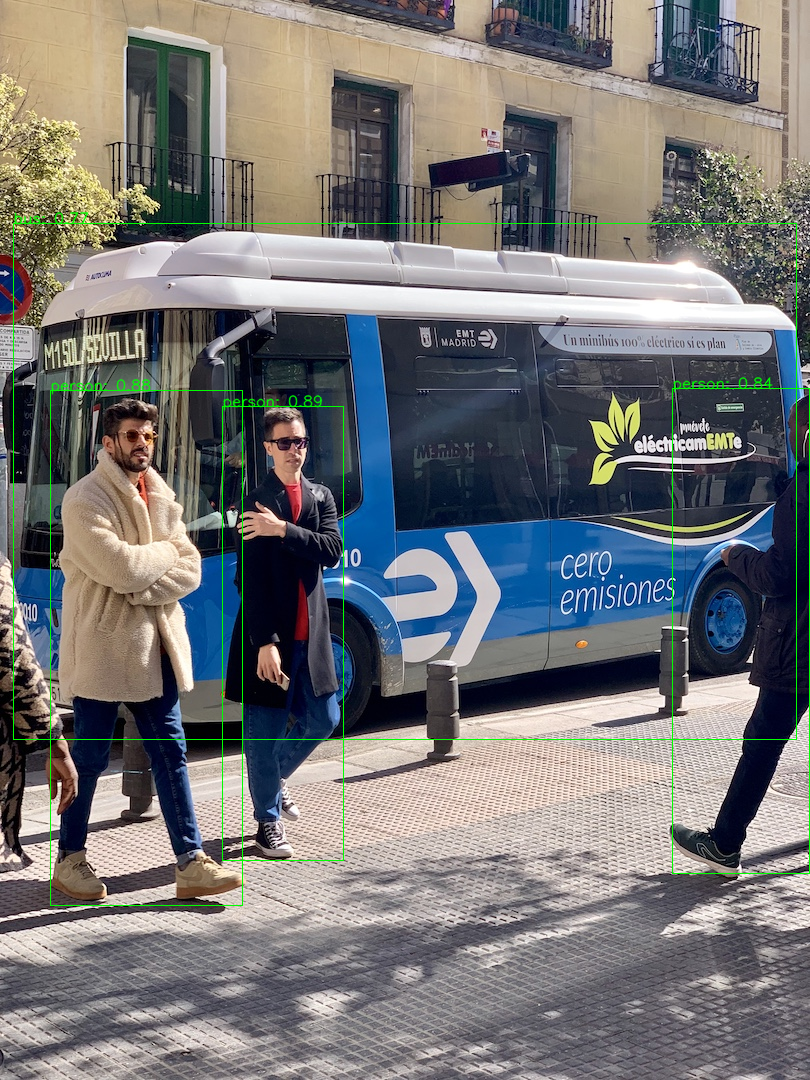

In [85]:
# Load image
im_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
print(f"im shape: {im_rgb.shape}")

# Preprocess
# https://github.com/ultralytics/ultralytics/blob/3c88bebc9514a4d7f70b771811ddfe3a625ef14d/examples/YOLOv8-OpenCV-ONNX-Python/main.py#L23C57-L31
im_rgb_r = cv2.resize(im_rgb, (640,640), interpolation=cv2.INTER_AREA)
#print(im_rgb_r.shape)
#im_rgb_r = resize_image(im_rgb,640)
x = im_rgb_r.astype(np.float32) / 255.0
x = np.transpose(x, (2, 0, 1))
x = np.expand_dims(x, axis=0)
#x = cv2.dnn.blobFromImage(im_bgr, scalefactor=1 / 255, size=(640, 640), swapRB=True)

# Inference
outputs = inf.run(None, {input_name: x})
#print(outputs[0].shape)

# Ge  info outpus output0: 1x38x8400, output1: 1x32x160x160
output = outputs[0]
batch_size = output.shape[0] # 1
num_features = output.shape[1] # 38  4+num_classes+32
num_detections = output.shape[2] # 8400

height_r = im_rgb_r.shape[0]
width_r = im_rgb_r.shape[1]
height = im_rgb.shape[0]
width = im_rgb.shape[1]
scale_y = height/height_r
scale_x = width/width_r

boxes_list = []
scores_list = []
scores_id_list = []
# Get results
for i in range(0, num_detections):

    scores  = []
    for j in range(0, len(classes)):
        scores.append(output[0][4+j][i])
    scores = np.array(scores)
    id = np.argmax(scores)
    score = scores[id]
    if score>score_threshold:
        #print(f"score: {score:.4f}, id: {id}")
        x = output[0][0][i]*scale_x # center box x already wrt 640
        y = output[0][1][i]*scale_y # benter box y already wrt 640
        w = output[0][2][i]*scale_x # width
        h = output[0][3][i]*scale_y # height
        x1 = int((x-w/2))
        y1 = int((y-h/2))
        x2 = int((x+w/2))
        y2 = int((y+h/2))
        boxes_list.append([x1,y1,x2,y2])
        scores_list.append(score)
        scores_id_list.append(id)

        #print(f"score: {score}, id: {id} x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")
        #cv2.rectangle(im_rgb_r, (x1, y1), (x2, y2), (0, 255, 0), 1)
        #cv2.putText(im_rgb_r, f"{classes[id]}: {score:.2f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        #print(f"{classes[id]}: {score:.2f}")

# Perform non-maximum suppression
indices = cv2.dnn.NMSBoxes(boxes_list, scores_list, score_threshold, iou_threshold)

# Use the indices to select the boxes and scores that were kept
boxes_after_nms = [boxes_list[i] for i in indices]
scores_after_nms = [scores_list[i] for i in indices]
scores_id_after_nms = [scores_id_list[i] for i in indices]

for box, score, id in zip(boxes_after_nms,scores_after_nms, scores_id_after_nms):
#for box, score, id in zip(boxes_list,scores_list, scores_id_list):
    x1, y1, x2, y2 = np.array(box).astype(int)
    cv2.rectangle(im_rgb, (x1, y1), (x2, y2), (0, 255, 0), 1)
    cv2.putText(im_rgb, f"{classes[id]}: {score:.2f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
    print(f"{classes[id]}: {score:.2f}")

#im_bgr = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2BGR)
display(Image.fromarray(im_rgb))
